# Long Short Term Memory (LSTM)

Recurrent neural networks can in principle use information from events that occurred many time steps earlier to make predictions at the current time step. However, in practice RNNs struggle to make use of long-term dependencies in the data.

Recall the equation describing the backpropagation of errors in an MLP:

$$
\begin{align}
\delta^{(k)}=\sigma'(\boldsymbol a^{(k)})(\mathbf W^{(k)})^T\delta^{(k+1)}
\end{align}
$$

for $k=1,\cdots,L$, which indexes the hidden layers, and the corresponding equation for the backpropagation through time (BPTT) algorithm:

$$
\begin{align}
\delta_{t-1}^{(k)} = \sigma'(\boldsymbol a_{t-1}^{(k)})(\mathbf W_{hh}^{(k)})^T\delta_t^{(k)}
\end{align}
$$

for $t=1,\cdots,T$. Here, $k$ indexes the stacked recurrent layers and $t$ indexes the time steps. The above equations indicate a fundamental problem of training neural networks: the vanishing gradients problem. 

Gradients can explode or vanish with a large number of layers, or a large number of time steps. This problem is particularly bad int he case of RNNs, where the length of sequences can be long.

The Long Short Term Memory (LSTM) network mitigates the effect of vanishing gradients and allow the recurrent neural network to remember things for a long time.

The LSTM has inputs $\boldsymbol x_t\in\mathbb R^{n_{k-1}}$ and $\boldsymbol h_{t-1}\in\mathbb R^{n_k}$ just as regular RNNs. However, it also includes an internal cell state $\boldsymbol c_t\in\mathbb R^{n_k}$ that allows the unit to store and retain information.


There is no neural network lyaer that operates directly on the cell state. This means that information is more freely able to travel across time steps in the cell state.

The role of the hidden state is to manage the information flow in and out of the cell state, according to the signals provided in the inputs $\boldsymbol h_{t-1}$ and $\boldsymbol x_t$.

### The forget gate

![lstm-forget-gate](../../figures/lstm-forget-gate.png)

The forget gate determines what information should be erased from the cell state. The information is controlled by signals in the inputs $\boldsymbol h_{t-1}$ and $\boldsymbol x_t$ according to the following equation:

$$
\begin{align}
\boldsymbol f_t = \sigma\left( \mathbf W_f \cdot [\boldsymbol x_t, \boldsymbol h_{t-1}] + \boldsymbol b_f \right)
\end{align}
$$

where $[\boldsymbol x_t, \boldsymbol h_{t-1}] \in \mathbb R^{n_k\times (n_k+n_{k-1})}$ is the concatenation of $\boldsymbol x_t$ and $\boldsymbol h_{t-1}, \mathbf W_f\in\mathbb R^{n_k\times (n_k +n_{k-1})}$, $\boldsymbol b_f\in\mathbb R^{n_k}$ and $\sigma$ is the sigmoid activation function. Note that entries of $\boldsymbol f_t$ will be close to one for large positive pre-activation values, and close to zero for large negative pre-activation values. The cell state is then updated

$$
\begin{align}
\boldsymbol c_t \leftarrow \boldsymbol f_t \odot \boldsymbol c_{t-1}
\end{align}
$$

where $\odot$ is the Hadamard (element-wise) product, so that selected entries of the cell state $\boldsymbol c_{t-1}$ are erased, while others are retained.

### The input and content gates

![lstm-input-content-gate](../../figures/lstm-input-content-gate.png)

The input gate determines when information should be written into the cell state. The content gate contains the information to be written.

The input and content gates are a combination of sigmoid and tanh activation gates:

$$
\begin{align}
\boldsymbol i_t = \sigma\left( \mathbf W_i \cdot [\boldsymbol x_t, \boldsymbol h_{t-1}] + \boldsymbol b_i \right)
\\
\tilde {\boldsymbol c}_t = \tanh (\mathbf W_c\cdot [\boldsymbol x_t, \boldsymbol h_{t-1}] + \boldsymbol b_c)
\end{align}
$$

where $\mathbf W_i, \mathbf W_c \in \mathbb R^{n_k\times(n_k+n_{k-1})}$ and $\boldsymbol b_i,\boldsymbol c\in\mathbb R^{n_k}$. In a similar way to the forget gate, the input gate $\boldsymbol i_t$, is used to 'zero out' selected entries in the content signal $\tilde{\boldsymbol c}_t$. The content entries that are allowed through the gate are then added into the cell state:

$$
\begin{align}
\boldsymbol c_t \leftarrow \boldsymbol c_t + \boldsymbol i_t \odot \tilde{\boldsymbol c}_t
\end{align}
$$

### The output gate

![lstm-output-gate](../../figures/lstm-output-gate.png)

Finally, the output gate decides which cell state values should be output in the hidden state.

The output gate is another sigmoid gate that releases information from the cell state after passing through a tanh activation:

$$
\begin{align}
\boldsymbol o_t = \sigma\left( \mathbf W_o \cdot [\boldsymbol x_t, \boldsymbol h_{t-1}] + \boldsymbol b_o \right)
\boldsymbol h_t = \boldsymbol o_t \odot \tanh(\boldsymbol c_t)
\end{align}
$$

In [1]:
! pip3 install torchinfo


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch import optim
from torchinfo import summary
import re
from collections import defaultdict

In [19]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
# Load the data

df = pd.read_csv("../../datasets/tweets/tweets.csv")
df = df[['text', 'airline_sentiment', 'airline_sentiment_confidence']]

In [4]:
df.head()

,text,airline_sentiment,airline_sentiment_confidence
0,@VirginAmerica What @dhepburn said.,neutral,1.0000
1,@VirginAmerica plus you've added commercials t...,positive,0.3486
2,@VirginAmerica I didn't today... Must mean I n...,neutral,0.6837
3,@VirginAmerica it's really aggressive to blast...,negative,1.0000
4,@VirginAmerica and it's a really big bad thing...,negative,1.0000


In [5]:
# Split the data into training, validation and test sets

train_df, val_df = train_test_split(df, test_size = 0.4)
val_df, test_df = train_test_split(val_df, test_size = 0.5)

In [6]:
# Save the splits to csv files

train_df.to_csv("../../datasets/tweets/train.csv", index=False)
val_df.to_csv("../../datasets/tweets/val.csv", index=False)
test_df.to_csv("../../datasets/tweets/test.csv", index=False)

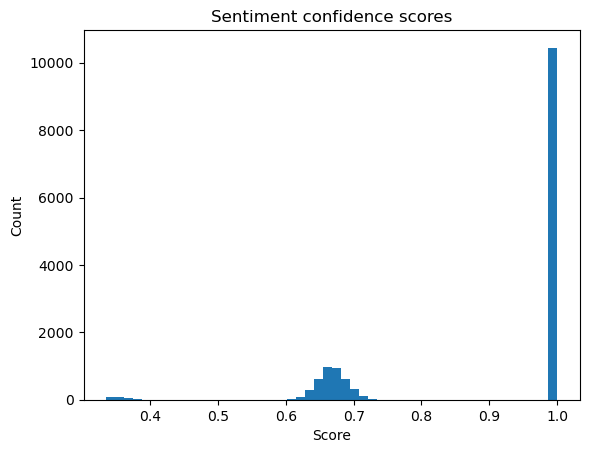

In [7]:
# Plot a histogram of confidence scores

plt.hist(df['airline_sentiment_confidence'], bins=50)
plt.title("Sentiment confidence scores")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

#### Preprocessing layers

PyTorch does not accept strings in tensor or datasets, therefore, we need to apply Preprocessing steps while creating the Dataset. To do this, we can create a custom Dataset.

We will need to convert the string data into a numeric representation for the models to process it.

In our custom dataset we will:
- Look at the output labels and convert them to a one-hot encoding.
- Process the input tweet text and vectorize it

In [10]:
def preprocess_text(sentences):
    all_words = defaultdict(int)
    max_len = 0
    for sentence in sentences:
        sentence_len = 0
        words = sentence.lower().strip().split()
        for word in words:
            # Remove all non-alphanumeric characters
            word = re.sub(r'[^a-zA-Z0-9]', '', word)
            if word == "":
                continue
            all_words[word] += 1
            sentence_len += 1
        if sentence_len > max_len:
            max_len = sentence_len
    vocab = sorted(all_words.items(), key=lambda x:x[1], reverse=True)
    word_to_idx = {word[0]: i for i, word in enumerate(vocab)}
    return word_to_idx, max_len

In [11]:
vocab_size = 1000
word_to_idx, max_sentence_len = preprocess_text(df["text"])

In [14]:
def tokenise(words, word_to_idx, max_vocab_size):
    tokenised_sentence = []
    # remove empty words
    words = list(filter(None, words))
    for word in words:
        if word in word_to_idx:
            token = word_to_idx[word] + 2
            if token >= max_vocab_size:
                tokenised_sentence.append(1)
            else:
                tokenised_sentence.append(token)
        else:
            tokenised_sentence.append(1)
    return tokenised_sentence

In [16]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, word_to_ix, max_vocab_size, max_sentence_len):
        df = pd.read_csv(csv_path)
        # Filter out low confidence labels
        self.df = df[df['airline_sentiment_confidence'] > 0.5]
        self.labels = {'negative': 0, 'neutral': 1, 'positive': 2}
        self.word_to_ix = word_to_ix
        self.max_vocab_size = max_vocab_size
        self.max_sentence_len = max_sentence_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        elem = self.df.iloc[index]
        words = elem["text"].strip().lower().split()
        words = [re.sub(r'[^a-zA-Z0-9]', '', word) for word in words]
        tokenised_text = tokenise(words, self.word_to_ix, self.max_vocab_size)
        text_tensor = torch.tensor(tokenised_text, dtype=torch.long)
        if self.max_sentence_len - len(text_tensor) > 0:
            pad = torch.zeros(self.max_sentence_len - len(text_tensor), dtype=torch.long)
            text_tensor = torch.cat((text_tensor, pad))
        label = self.labels[elem["airline_sentiment"]]
        return text_tensor, label

In [17]:
train_dataset = TweetDataset('../../datasets/tweets/train.csv', word_to_idx, vocab_size, max_sentence_len)
val_dataset = TweetDataset('../../datasets/tweets/val.csv', word_to_idx, vocab_size, max_sentence_len)
test_dataset = TweetDataset('../../datasets/tweets/test.csv', word_to_idx, vocab_size, max_sentence_len)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)

In [18]:
# View a sample from the training Dataset

for elem in train_dataset:
    print(elem)
    break

(tensor([ 18,   4,  23,   5, 488, 100,  48, 117,   1, 188, 405,   5, 527, 100,
          1, 182, 100,  32,  49,  42, 957,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]), 2)


#### Embedding layer

We are now able to process the text data into numerical form. However, the input integer tokens should be further processed to transform them into a representation that is more useful for the network. This is where the `Embedding` layer can be used - it creates a lookup table of vectors in $\mathbb{R}^D$ such that each integer token in the vocabulary has its own $D$-dimensional embedding vector.

In [20]:
# Create an embedding layer

embedding_dim = 10
embedding = nn.Embedding(vocab_size, embedding_dim).to(device)

In [23]:
# View the output of the embedding layer

for t, _ in train_dataset:
    print(t)
    print(embedding(t.to(device)).shape)
    break

tensor([ 18,   4,  23,   5, 488, 100,  48, 117,   1, 188, 405,   5, 527, 100,
          1, 182, 100,  32,  49,  42, 957,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0])
torch.Size([35, 10])


In [24]:
# Build the classifier

class extract_tensor(nn.Module):
    def forward(self, x):
        tensor, _ = x
        return tensor[:, -1, :]

lstm_classifier = nn.Sequential(
    embedding,
    nn.LSTM(input_size=embedding_dim, hidden_size=8, batch_first=True, bidirectional=True),
    extract_tensor(),
    nn.Linear(16,3)
).to(device)

In [25]:
summary(lstm_classifier, device=device)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Embedding: 1-1                         10,000
├─LSTM: 1-2                              1,280
├─extract_tensor: 1-3                    --
├─Linear: 1-4                            51
Total params: 11,331
Trainable params: 11,331
Non-trainable params: 0

In [28]:
def get_accuracy(pred, actual):
    total = len(pred)
    predicted = torch.argmax(pred, axis=1)
    correct = (predicted == actual).sum().item()
    return correct

def train(model, num_epochs, train_dl, val_dl):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Define loss function and optimiser
    optimizer = torch.optim.Adam(model.parameters())
    loss_function = torch.nn.CrossEntropyLoss()

    for epoch in range(0, num_epochs):

        # Initialise train and validation loss to 0
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0

        model.train()

        for train_input, train_target in train_dl:
            train_input = train_input.to(device)
            train_target = train_target.to(device)
            optimizer.zero_grad()
            predict = model(train_input)
            loss = loss_function(predict, train_target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += get_accuracy(predict, train_target)

        model.eval()

        for val_input, val_target in val_dl:
            val_input = val_input.to(device)
            val_target = val_target.to(device)
            predict = model(val_input)
            loss = loss_function(predict, val_target)

            val_loss += loss.item()
            val_acc += get_accuracy(predict, val_target)
        
        train_loss = train_loss / len(train_dl)
        val_loss = val_loss / len(train_dl)
        train_acc = train_acc / (len(train_dl) * 16)
        val_acc = val_acc / (len(val_dl) * 16)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print('Epoch: {} - Train Loss: {:.4f} - Validation Loss: {:.4f}'.format(epoch+1, train_loss, val_loss))   
        print('Epoch: {} - Train Acc: {:.4f} - Validation Acc: {:.4f}'.format(epoch+1, train_acc, val_acc))   
    
    return {'loss': train_losses, 'val_loss': val_losses, 'acc': train_accs, 'val_acc': val_accs}

In [31]:
history = train(lstm_classifier, 50, train_dl=train_dataloader, val_dl=val_dataloader)

Epoch: 1 - Train Loss: 0.5492 - Validation Loss: 0.2209
Epoch: 1 - Train Acc: 0.7781 - Validation Acc: 0.7205
Epoch: 2 - Train Loss: 0.5378 - Validation Loss: 0.2175
Epoch: 2 - Train Acc: 0.7823 - Validation Acc: 0.7205
Epoch: 3 - Train Loss: 0.5246 - Validation Loss: 0.2175
Epoch: 3 - Train Acc: 0.7896 - Validation Acc: 0.7288
Epoch: 4 - Train Loss: 0.5153 - Validation Loss: 0.2145
Epoch: 4 - Train Acc: 0.7942 - Validation Acc: 0.7361
Epoch: 5 - Train Loss: 0.5040 - Validation Loss: 0.2202
Epoch: 5 - Train Acc: 0.8039 - Validation Acc: 0.7271
Epoch: 6 - Train Loss: 0.4971 - Validation Loss: 0.2285
Epoch: 6 - Train Acc: 0.8088 - Validation Acc: 0.7198
Epoch: 7 - Train Loss: 0.4860 - Validation Loss: 0.2201
Epoch: 7 - Train Acc: 0.8155 - Validation Acc: 0.7354
Epoch: 8 - Train Loss: 0.4788 - Validation Loss: 0.2196
Epoch: 8 - Train Acc: 0.8179 - Validation Acc: 0.7392
Epoch: 9 - Train Loss: 0.4703 - Validation Loss: 0.2271
Epoch: 9 - Train Acc: 0.8236 - Validation Acc: 0.7323
Epoch: 10 

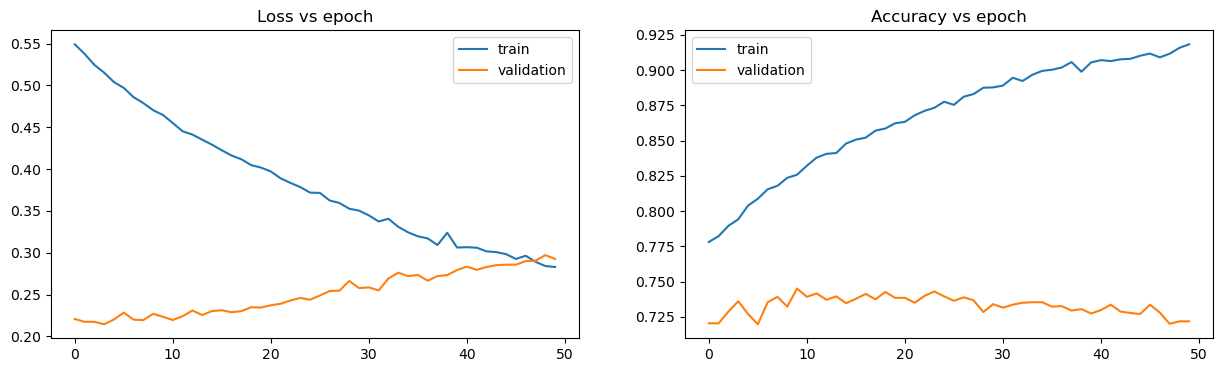

In [32]:
# Plot the learning curves

fig = plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.legend()
plt.title("Loss vs epoch")

plt.subplot(1, 2, 2)
plt.plot(history['acc'], label='train')
plt.plot(history['val_acc'], label='validation')
plt.legend()
plt.title("Accuracy vs epoch")

plt.show()

In [33]:
def eval_model(model, test_dl):

    loss_fn = torch.nn.CrossEntropyLoss()

    model.eval()
    test_loss = 0

    for test_input, test_target in test_dl:
        test_input = test_input.to(device)
        test_target = test_target.to(device)
        predict = model(test_input)
        loss = loss_fn(predict, test_target)

        test_loss += loss.item()
        test_acc = get_accuracy(predict, test_target)
    
    test_loss = test_loss / len(test_dl)

    return {'test_loss': test_loss, 'test_accuracy': test_acc}

In [35]:
metrics = eval_model(lstm_classifier, test_dataloader)
print(metrics["test_loss"])
print(metrics["test_accuracy"])

0.82789246092795
10


In [37]:
# View some model predictions on the test set

def token_to_word(token, idx_to_word):
    if token == 0:
        return ''
    elif token == 1:
        return 'OOV'
    else:
        return idx_to_word[token-2][0]

output_labels = np.array(['positive', 'negative', 'neutral'])

for text_batch, label_batch in test_dataloader:
    # we need to add 1 dimension as the batch dim
    ground_truth = output_labels[label_batch]
    predicted_label = lstm_classifier(text_batch.to(device))
    predicted_label_ints = np.argmax(predicted_label.cpu().detach().numpy(), axis=1)
    predicted_labels = output_labels[predicted_label_ints]
    break

idx_to_word = sorted(word_to_idx.items(), key=lambda item: item[1])

for t, l, g in zip(text_batch, predicted_labels, ground_truth):
    print([token_to_word(w_token, idx_to_word) for w_token in t.numpy()])
    print("True label: {}\nPredicted label: {}\n".format(g, l))

['americanair', 'OOV', 'american', 'when', 'did', '2', 'hour', 'hold', 'times', 'OOV', 'the', 'OOV', 'OOV', 'have', 'you', 'heard', 'of', 'OOV', 'OOV', 'during', 'weather', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
True label: positive
Predicted label: positive

['southwestair', 'why', 'can', 'we', 'no', 'longer', 'change', 'OOV', 'with', 'a', 'companion', 'online', 'been', 'doing', 'it', 'for', 'years', 'now', 'get', 'message', 'cant', 'be', 'done', 'online', '', '', '', '', '', '', '', '', '', '', '']
True label: positive
Predicted label: positive

['always', 'have', 'it', 'together', 'youre', 'OOV', 'rt', 'virginamerica', 'OOV', 'youre', 'so', 'OOV', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
True label: neutral
Predicted label: neutral

['united', 'this', 'flight', 'has', 'been', 'amazing', 'this', 'is', 'the', 'best', 'flight', 'i', 'have', 'ever', 'been', 'on', 'i', 'am', 'not', 'OOV', 'service', 'is', 'OOV', '', '', 